<a href="https://colab.research.google.com/github/GeneA2003/Poop/blob/main/FinalProjectIntrotoAI_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Read Codeblock

In [1]:
from typing import Literal
import numpy as np

DATASET_INFO = {
    "digit": {
        "images": {
            "train": "data/digitdata/trainingimages",
            "validation": "data/digitdata/validationimages",
            "test": "data/digitdata/testimages",
        },
        "labels": {
            "train": "data/digitdata/traininglabels",
            "validation": "data/digitdata/validationlabels",
            "test": "data/digitdata/testlabels",
        },
        "width": 28,
        "height": 28,
    },
    "face": {
        "images": {
            "train": "data/facedata/facedatatrain",
            "validation": "data/facedata/facedatavalidation",
            "test": "data/facedata/facedatatest",
        },
        "labels": {
            "train": "data/facedata/facedatatrainlabels",
            "validation": "data/facedata/facedatavalidationlabels",
            "test": "data/facedata/facedatatestlabels",
        },
        "width": 60,
        "height": 70,
    },
}


def load_data(
        dataset: Literal["digit", "face"],
        split: Literal["train", "validation", "test"],
):
    info = DATASET_INFO[dataset]

    # imgs
    ipath = info["images"][split]
    with open(ipath) as f:
        ilines = f.readlines()

    ibuf = np.zeros(shape=(len(ilines), info["width"]), dtype=np.uint8)

    for row, line in enumerate(ilines):
        for col, ch in enumerate(line):
            if ch == " ":
                pixel = 0
            elif ch == "+":
                pixel = 1
            elif ch == "#":
                pixel = 2
            else:
                continue
            ibuf[row, col] = pixel

    ibuf = ibuf.reshape(len(ilines) // info["height"], info["height"], info["width"])

    # labels
    lpath = info["labels"][split]
    with open(lpath) as f:
        llines = f.readlines()

    lbuf = np.zeros(shape=(len(llines)), dtype=np.uint8)
    for i, label in enumerate(llines):
        lbuf[i] = int(label)

    return ibuf, lbuf

imports

In [2]:
import numpy as np
import random
import time

#for charts and graphs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os




Unzip and Load Data

In [3]:
# unzip data
import zipfile
import os

if not os.path.exists("data"):
    with zipfile.ZipFile("data.zip", "r") as zip_ref:
        zip_ref.extractall("data")
        
# filepaths
train_data_file = "data/digitdata/trainingimages"
train_label_file = "data/digitdata/traininglabels"
val_data_file = "data/digitdata/validationimages"
val_label_file = "data/digitdata/validationlabels"
test_data_file = "data/digitdata/testimages"
test_label_file = "data/digitdata/testlabels"

face_train_data_file = "data/facedata/facedatatrain"
face_train_label_file = "data/facedata/facedatatrainlabels"
face_val_data_file   = "data/facedata/facedatavalidation"
face_val_label_file  = "data/facedata/facedatavalidationlabels"
face_test_data_file  = "data/facedata/facedatatest"
face_test_label_file = "data/facedata/facedatatestlabels"

def read_data_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return [line.rstrip("\n") for line in lines]

def extract_features(raw_data):
    features = []
    for i in range(0, len(raw_data), 28):
        image = raw_data[i:i+28]
        feature = [1 if ch != ' ' else 0 for row in image for ch in row]
        features.append(feature)
    return features


def read_labels(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return [int(line.strip()) for line in lines]

def load_dataset(data_file, label_file, size=None):
    raw_data = read_data_file(data_file)
    raw_labels = read_labels(label_file)

    features = extract_features(raw_data)
    if size is not None:
        combined = list(zip(features, raw_labels))
        random.shuffle(combined)
        features, raw_labels = zip(*combined[:size])

    return list(features), list(raw_labels)


Hyperparamaeters

In [4]:
DIGIT_UNROLLED_FEATURES = 28 * 28
FACE_UNROLLED_FEATURES = 60 * 70
NUM_CLASSES = 10
LEARNING_RATE = 0.1
EPOCHS = 10
DATA_POINT_PERC = 10
FACE_CLASSES = 2


# Helper Functions

In [5]:
# Helper Functions
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / e_x.sum(axis=0, keepdims=True)


Perception Class

In [6]:
class Perceptron:

    output = []
    training_times = []

    def run_percep_on_data(self, split, perceptron):



        self.train_func = {

            'face': self.trainFace,

            'digit': self.trainDigit,

        }



        if perceptron == 'face':

            classes = FACE_CLASSES

            features = FACE_UNROLLED_FEATURES



        elif perceptron == 'digit':

            classes = NUM_CLASSES

            features = DIGIT_UNROLLED_FEATURES

        else:

            return 'invalid input'



        images, labels = load_data(perceptron, split)

        images = images.reshape(images.shape[0], -1)  # Flatten 2D images into 1D feature vectors

        print(f'digit, {split}')



        #while loop allows for the data to be tested independently on increasing percents of data

        percent_of_data = 0.1

        while percent_of_data <= 1:

                print(f'Running {perceptron} on perc_of_data= {percent_of_data}' )
                
                start_time = time.time()

                self.bias = np.zeros(classes)

                self.weights = np.random.randn(features, classes) * 0.01

                self.train_func[perceptron](images,labels, percent_of_data)
                
                end_time = time.time() 
                training_time = end_time - start_time  
                self.training_times.append((percent_of_data, training_time))  

                percent_of_data = round(percent_of_data + 0.1, 2)

        #print(self.output)

        for data_percentage in self.output:

           print(f'data perc = {data_percentage[0]}')

           for index, epoch_data in enumerate(data_percentage[1]):

               print(f' epoch num = {index}')

               print(f'training =  {str(epoch_data[0])}, validation = {str(epoch_data[1])}')









    #Fixed the training by epochs

    # images[0] contains the num of images

    # pixel is a full image -> this means that it's currently set to view 10 images

    def trainDigit(self, images, labels, perc_of_data):

        vimages, vlabels = load_data('digit', 'validation')

        #added test set

        timages, tlabels = load_data('digit', 'train')



        #added to ensure that only a percentage of the data set is used

        max_image_len = int(images.shape[0] * perc_of_data)

        max_image_subset = images[0:max_image_len, :]

        epoch_data = []



        for j in range(EPOCHS):



            #count added to see if correct val

            correct_predictions = 0

            for row, pixel in enumerate(max_image_subset):

                #label is used to classify -> 10 indices for 10 different types of nums (0-9)

                label = np.zeros(NUM_CLASSES)



                #the label index that is the right value is marked 1

                label[labels[row]] = 1  # One-hot encoding



                #lin-outpout multiplies vertex pixel (1,784) by matrix weights of (784, 10)

                lin_output = np.dot(pixel, self.weights) + self.bias



                #softmax returns array of probability that digit matches each classification (0-9)

                prediction = softmax(lin_output)



                #gets the index/classification that has the highest prob

                predictedVal = np.argmax(prediction)



                if(labels[row] == predictedVal):

                    correct_predictions += 1



                error = label - prediction



                # Update weights and biases using the outer product

                self.weights += LEARNING_RATE * np.outer(error, pixel).T

                self.bias += LEARNING_RATE * error



            print('------')

            print(f' End of training on epoch {j}, perc_of_data = {perc_of_data}')

            print(f'# of correct predictions {correct_predictions}')

            print(f'digit training accur = {correct_predictions/max_image_len}')

            print('------')

            #check this

            validation_res = self.validate_digit(vimages, vlabels, j, self.weights, self.bias)

            epoch_data.insert(j,(correct_predictions/max_image_len, validation_res))

            correct_predictions = 0

        self.output.append((perc_of_data, epoch_data))

        self.test_digit(timages, tlabels, j, self.weights, self.bias)



    #classes changed to 0,1 ->ie face and not face using a num enum

    #tech don't need softmax bc lin_output can give a 0 or 1

    #can try to figure that out later



    def trainFace(self, images, labels, perc_of_data):

        vimages, vlabels = load_data('face', 'validation')

        #added test set

        timages, tlabels = load_data('face', 'train')





        #max_image_len = 45 & subset is (45, 4200)

        max_image_len = int(images.shape[0] * perc_of_data)

        max_image_subset = images[0:max_image_len, :]



        for j in range(EPOCHS):

            correct_predictions = 0

            for row, pixel in enumerate(max_image_subset):

                label = np.zeros(FACE_CLASSES)

                label[labels[row]] = 1  # One-hot encoding



                lin_output = np.dot(pixel, self.weights) + self.bias



                prediction = softmax(lin_output)



                error = label - prediction



                predictedVal = np.argmax(prediction)

                if(labels[row] == predictedVal):

                    correct_predictions += 1



                # Update weights and biases using the outer product

                self.weights += LEARNING_RATE * np.outer(error, pixel).T

                self.bias += LEARNING_RATE * error



            print('------')

            print(f'End of FACE training on epoch {j}, perc_of_data = {perc_of_data}')

            print(f'# of correct predictions = {correct_predictions}')

            print(f'Face training accur = {correct_predictions/max_image_len}')

            print('------')

            correct_predictions = 0

            self.validate_face(vimages, vlabels, j, self.weights, self.bias)

        self.test_face(timages, tlabels, j, self.weights, self.bias)



    #doesn't affect weights -> just used to see how well the model is doing against

    #unseen examples

    def validate_digit(self, images, labels, i, weights, bias) -> float:



        #images start as (1000, 28,28) -> (1000, 784) after reshape

        images = images.reshape(images.shape[0], -1)

        correct_predictions = 0



        #use entire validation set each epoch -> gives more reliable indicator of performance

        for row, pixel in enumerate(images):

            label = np.zeros(NUM_CLASSES)

            label[labels[row]] = 1  # One-hot encoding

            lin_output = np.dot(pixel, self.weights) + self.bias

            prediction = softmax(lin_output)



            if np.argmax(prediction) == labels[row]:

                correct_predictions += 1

        print(f'Digit Validation accur = {correct_predictions} / {images.shape[0]}, perc_accur = {correct_predictions / images.shape[0]}')

        return correct_predictions / images.shape[0]



    def validate_face(self, images, labels, i, weights, bias):

            images = images.reshape(images.shape[0], -1)

            correct_predictions = 0



            for row, pixel in enumerate(images):

                label = np.zeros(FACE_CLASSES)

                label[labels[row]] = 1  # One-hot encoding

                lin_output = np.dot(pixel, self.weights) + self.bias

                prediction = softmax(lin_output)



                if np.argmax(prediction) == labels[row]:

                    correct_predictions += 1

            print(f'Face Validation accur = {correct_predictions} / {images.shape[0]}, perc_accur = {correct_predictions / images.shape[0]}')



    def test_face(self, images, labels, i, weights, bias):

        #copied from validateface

        images = images.reshape(images.shape[0], -1)

        correct_predictions = 0



        for row, pixel in enumerate(images):

            label = np.zeros(FACE_CLASSES)

            label[labels[row]] = 1  # One-hot encoding

            lin_output = np.dot(pixel, self.weights) + self.bias

            prediction = softmax(lin_output)



            if np.argmax(prediction) == labels[row]:

                correct_predictions += 1

        print(f'Face Test accur = {correct_predictions} / {images.shape[0]}, perc_accur = {correct_predictions / images.shape[0]}')



    def test_digit(self, images, labels, i, weights, bias):

        #copied validate digit

        #images start as (1000, 28,28) -> (1000, 784) after reshape

        images = images.reshape(images.shape[0], -1)

        correct_predictions = 0



        #use entire validation set each epoch -> gives more reliable indicator of performance

        for row, pixel in enumerate(images):

            label = np.zeros(NUM_CLASSES)

            label[labels[row]] = 1  # One-hot encoding

            lin_output = np.dot(pixel, self.weights) + self.bias

            prediction = softmax(lin_output)



            if np.argmax(prediction) == labels[row]:

                correct_predictions += 1

        print(f'Digit Test accur = {correct_predictions} / {images.shape[0]}, perc_accur = {correct_predictions / images.shape[0]}')

        return correct_predictions / images.shape[0]







Sample Digit

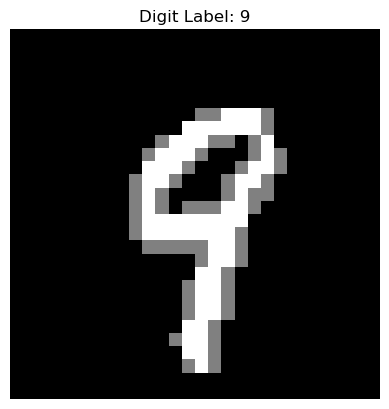

In [7]:
import matplotlib.pyplot as plt

imgs, labels = load_data("digit", "train")

# Pick random image
idx = random.randint(0, len(imgs) - 1)
img = imgs[idx].reshape(28, 28)

# Display image
plt.imshow(img, cmap="gray")
plt.title("Digit Label: " + str(labels[idx]))
plt.axis("off")
plt.show()

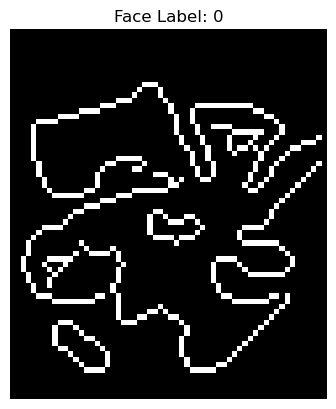

In [8]:
imgs, labels = load_data("face", "train")

idx = random.randint(0, len(imgs) - 1)

# Reshape and display
img = imgs[idx].reshape(70, 60)
plt.imshow(img, cmap="gray")
plt.title("Face Label: " + str(labels[idx]))
plt.axis("off")
plt.show()

In [11]:
def export_perceptron_results(perceptron_output, training_times, output_dir='Charts and Graphs'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        # Remove old PDF files
        for file in os.listdir(output_dir):
            if file.endswith('.pdf') and file.startswith('partA_'):
                os.remove(os.path.join(output_dir, file))

    # Process results into DataFrame
    results = []
    for data_percentage, epoch_data in perceptron_output:
        for epoch_num, (train_acc, val_acc) in enumerate(epoch_data):
            results.append({
                'Data %': data_percentage * 100,
                'Epoch': epoch_num + 1,
                'Training Accuracy': train_acc,
                'Validation Accuracy': val_acc
            })
    
    df = pd.DataFrame(results)
    
    # Add training times to DataFrame
    times_df = pd.DataFrame(training_times, columns=['Data %', 'Training Time'])
    times_df['Data %'] *= 100  # Convert to percentage
    df = df.merge(times_df, on='Data %')

    # Export tables
    with PdfPages(f'{output_dir}/partA_classification_tables.pdf') as pdf:
        plt.figure(figsize=(12, 6))
        plt.suptitle('Perceptron Results - Part A', fontsize=14, y=1.05)
        plt.axis('tight')
        plt.axis('off')
        
        summary = df.groupby('Data %')[['Training Accuracy', 'Validation Accuracy', 'Training Time']].mean()
        table_data = [[f"{row_name:.1f}%"] + [f"{val:.4f}" for val in row] 
                     for row_name, row in zip(summary.index, summary.values)]
        
        table = plt.table(
            cellText=table_data,
            colLabels=['Data %', 'Avg Training Acc', 'Avg Validation Acc', 'Avg Time (s)'],
            loc='center',
            cellLoc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight', pad_inches=0.5)
        plt.close()

    # Export learning curves
    with PdfPages(f'{output_dir}/partA_learning_curves.pdf') as pdf:
        plt.figure(figsize=(10, 6))
        plt.plot(df['Data %'].unique(), 
                df.groupby('Data %')['Training Accuracy'].mean(), 
                'b.-', label='Training', linewidth=2, markersize=8)
        plt.plot(df['Data %'].unique(), 
                df.groupby('Data %')['Validation Accuracy'].mean(), 
                'r.-', label='Validation', linewidth=2, markersize=8)
        plt.xlabel('Percentage of Training Data', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Perceptron Learning Curves - Part A', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')
        plt.close()

    # Export training times
    with PdfPages(f'{output_dir}/partA_training_times.pdf') as pdf:
        plt.figure(figsize=(10, 6))
        plt.plot(df['Data %'].unique(), 
                df.groupby('Data %')['Training Time'].mean(), 
                'g.-', linewidth=2, markersize=8)
        plt.xlabel('Percentage of Training Data', fontsize=12)
        plt.ylabel('Training Time (seconds)', fontsize=12)
        plt.title('Perceptron Training Times - Part A', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')
        plt.close()

    # Print summary
    print(f"\nPart A Results exported to {output_dir}/")
    print("\nPerceptron Classification Summary:")
    print(summary.round(4).to_string())

Main

In [13]:


if __name__ == "__main__":

    perc = Perceptron()

    #perc.run_percep_on_data("train", "face")

    perc.run_percep_on_data("train", "digit")

    #perc.perceptron_digits("train")

    #perc.perceptron_faces("train")
    
    export_perceptron_results(perc.output, perc.training_times)

digit, train
Running digit on perc_of_data= 0.1
------
 End of training on epoch 0, perc_of_data = 0.1
# of correct predictions 312
digit training accur = 0.624
------
Digit Validation accur = 665 / 1000, perc_accur = 0.665
------
 End of training on epoch 1, perc_of_data = 0.1
# of correct predictions 412
digit training accur = 0.824
------
Digit Validation accur = 688 / 1000, perc_accur = 0.688
------
 End of training on epoch 2, perc_of_data = 0.1
# of correct predictions 448
digit training accur = 0.896
------
Digit Validation accur = 711 / 1000, perc_accur = 0.711
------
 End of training on epoch 3, perc_of_data = 0.1
# of correct predictions 458
digit training accur = 0.916
------
Digit Validation accur = 776 / 1000, perc_accur = 0.776
------
 End of training on epoch 4, perc_of_data = 0.1
# of correct predictions 483
digit training accur = 0.966
------
Digit Validation accur = 769 / 1000, perc_accur = 0.769
------
 End of training on epoch 5, perc_of_data = 0.1
# of correct pred